In [1]:
import scanpy as sc

In [2]:
import pickle

In [3]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
import sys
import os
from importlib import reload

# Add the path of your package
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/GlossPath/")
sys.path.insert(0, package_path)
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/Gloss/")
sys.path.insert(0, package_path)

In [7]:
def generate_pathways_dict(fn, mygenes, change_case = False):
    pathways = {}
    with open(fn, "r") as f:
        for line in f:
            line = line.strip()
            words = line.split("\t")
            if change_case:
                words = [ word.capitalize() for word in words]
            pathway = words[2:]
            pathway = list(set(pathway).intersection(mygenes))
            pathways[words[0]] = pathway
            #if len(pathway) < 200 and len(pathway) > 3:
            #    pathways[words[0]] = pathway
    return pathways

In [8]:
def get_hallmark_pathways(gene_ad):
    hallmark_pathways_path = '../pathway_collections/mouse_hallmark_genes.gmt.txt'
    mygenes = set(gene_ad.var.index)
    path_dict = generate_pathways_dict(hallmark_pathways_path, mygenes)
    return path_dict

def get_kegg_pathways(gene_ad):
    with open('../pathway_collections/kegg_pathways_sep18_2024.pkl', 'rb') as handle:
        kegg_gene_sets = pickle.load(handle)
    
    mygenes = set(gene_ad.var.index)
    for key, value in kegg_gene_sets.items():
        kegg_gene_sets[key] = list(set([gene for gene in value if gene in mygenes]))
        
    empty = []
    for key in kegg_gene_sets:
        if not kegg_gene_sets[key]:
            empty.append(key)

    for pathway in empty:
        kegg_gene_sets.pop(pathway)
        
    path_dict = kegg_gene_sets
    return path_dict

In [9]:
with open('../pathway_computations/cellchatdb.pickle', 'rb') as handle:
    cellchatdb = pickle.load(handle)
with open('../pathway_computations/cd40neighbors.pickle', 'rb') as handle:
    cd40neighbors = pickle.load(handle)

In [10]:
with open('../pathway_computations/random_neighbors.pickle', 'rb') as handle:
    random_neighbors = pickle.load(handle)

In [11]:
with open('../pathway_computations/humanbase_cd40neighbors.pickle', 'rb') as handle:
    humanbase_cd40neighbors = pickle.load(handle)

In [12]:
with open('../pathway_computations/cd40_filtered.pickle', 'rb') as handle:
    cd40_filtered_neighbors = pickle.load(handle)

In [13]:
with open('../pathway_computations/combined_cellchatdb_nn_signaling.pickle', 'rb') as handle:
    combined_c_n = pickle.load(handle)

In [14]:
with open('../pathway_computations/combined_cellchatdb_nn_signaling_relaxed.pickle', 'rb') as handle:
    combined_c_n_relaxed = pickle.load(handle)

In [15]:
from GlossPath.prepdata import PrepData

In [16]:
prepped_datas = {}
for i in range(10):
    print(i)
    datapath = 'datasets/{}_gut_data_perturbed_combined_c_n_relaxed_6_v2_oct_26_2024.h5ad'.format(i)
    prepped_datas[i] = PrepData(datapath, 'hallmark', 'avg_sample_hto', 'total_counts', 'biotin_raw_perturbed')

0
1
2
3
4
5
6
7
8
9


In [17]:
gut_adatas = {}
for i in range(10):
    gut_adatas[i] = prepped_datas[i].adata

In [18]:
datasets = {
    'gut' : gut_adatas,
    #'lcmv_sys' : lcmv_sys_ad,
    #'lcmv_ln' : lcmv_ln_ad,
    #'l_tumor' : l_tumor_adatas,
}

In [19]:
datasets['gut']

{0: AnnData object with n_obs × n_vars = 3677 × 14280
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin', 'cell_norm_biotin', 'sample_type', 'leiden', 'leiden ', 'log normalized biotin', 'normalized biotin', 'S_score', 'G2M_score', 'phase', 'annotation', 'annotation ', ' leiden ', 'cluster', ' annotation ', 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'I

In [20]:
## coefficients

# uLIPSTIC gut
#with open('../model_ulipstic_gut/experiment_evaluations/gut_glosspath_bootstrap_hallmark_oct9_2024.pickle', 'rb') as handle:
#    gut_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv sys
#with open('../model_ulipstic_lcmv/experiment_evaluations/', 'rb') as handle:
#    lcmv_sys_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv ln
#with open('../model_ulipstic_lcmv/experiment_evaluations/grouplasso_hallmark_bootstrap_u_lcmv_ln_oct3_2024.pickle', 'rb') as handle:
#    lcmv_ln_glasso_res = pickle.load(handle)
# LIPSTIC tumor

gut_perturb_bootstraps = {}
for i in range(10):
    print(i)
    with open('../model_ulipstic_gut/experiment_evaluations/{}_gut_perturbed_relaxed_6_new_gloss_bootstrap_hallmark_oct26_2024.pickle'.format(i), 'rb') as handle:
        gut_perturb_bootstraps[i] = pickle.load(handle)

0
1
2
3
4
5
6
7
8
9


In [21]:
gut_coefficient_results = {}
for i in range(10):
    gut_coefficient_results[i] = gut_perturb_bootstraps[i].response_individual_genes

In [22]:
coefficient_results = {
    #'gut' : gut_glasso_res.response_individual_genes,
    #'lcmv_sys' : lcmv_sys_glasso_res,
    #'lcmv_ln' : lcmv_ln_glasso_res,
    'gut' : gut_coefficient_results
}

In [23]:
resolution_subsets = {

'gut' : {
    'annotation' : ['CD4']
}

}

In [24]:
def make_corr_df(ad, norm_layer, biotin_norm=False):
    genes = ad.var_names
    spearman_rhos = []
    gene_vals = ad.layers[norm_layer].toarray()
    print(gene_vals.shape)
    if not biotin_norm:
        biotin_vals = ad.obs['new_biotin']
    else:
        biotin_vals = ad.obs['other_new_biotin']
    for i, g in enumerate(genes):
        mygene = gene_vals[:,i]
        spearman_rhos.append(spearmanr(biotin_vals, mygene))
    df = pd.DataFrame({"gene": genes, 
                       "corr": [ c[0] for c in spearman_rhos],
                       "sig": [ c[1] for c in spearman_rhos],
                      })
    
    df["top gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=10)["gene"]) + 
    list(df.sort_values("corr", ascending=True).head(n=10)["gene"]))
    df["top 30 corr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=30)["gene"]))
    df["top 30 anticorr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=True).head(n=30)["gene"]))
    df = df.sort_values("corr") 
    df["i"] = [i/10 for i in range(len(genes))]
    
    df['is_FDR_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[0]
    df['corrected_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[1]
    df.dropna(inplace=True)
    return df

In [25]:
datasets['gut']

{0: AnnData object with n_obs × n_vars = 3677 × 14280
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin', 'cell_norm_biotin', 'sample_type', 'leiden', 'leiden ', 'log normalized biotin', 'normalized biotin', 'S_score', 'G2M_score', 'phase', 'annotation', 'annotation ', ' leiden ', 'cluster', ' annotation ', 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'I

In [26]:
corr_results = {}

for i in range(10):
    print(i)
    corr_results[i] = {}
    for data in resolution_subsets:
        print(data)
        corr_results[i][data] = {}
        for resolution in resolution_subsets[data]:
            corr_results[i][data][resolution] = {}
            for ctype in resolution_subsets[data][resolution]:
                corr_results[i][data][resolution][ctype] = make_corr_df(datasets[data][i][datasets[data][i].obs[resolution] == ctype], norm_layer='log_lib_norm', biotin_norm=True)

0
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


5
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


6
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


7
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


8
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


9
gut
(915, 14280)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [27]:
corr_results

{0: {'gut': {'annotation': {'CD4':          gene      corr            sig  top gene  top 30 corr gene  \
    4651   Tmsb10 -0.633495  8.130095e-104      True             False   
    8637     Tcf7 -0.588510   2.280181e-86      True             False   
    8364     Dgka -0.499978   4.926895e-59      True             False   
    2572    Rps20 -0.493043   3.240960e-57      True             False   
    10017    Ighm -0.485964   2.107531e-55      True             False   
    ...       ...       ...            ...       ...               ...   
    10108   Actn2  0.608124   1.241350e-93      True              True   
    10646    Gzma  0.635292  1.419123e-104      True              True   
    9027     Ccl5  0.669200  7.111983e-120      True              True   
    5461     Nkg7  0.676010  3.394843e-123      True              True   
    8895    Itgae  0.683640  5.031802e-127      True              True   
    
           top 30 anticorr gene       i  is_FDR_sig  corrected_sig  
    465

In [28]:
dataset = 'gut'
res = 'annotation'
ctype = 'CD4'

In [29]:
i = 0

In [30]:
# filter a dict to only include genes in that data

test_ad = datasets[dataset][i]
coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
corr = corr_results[i][dataset][res][ctype]

# run the enrichment over correlations or coefficients

In [31]:
mycoefs = coef 
mycoefs.columns[-50:]

Index(['Cd7', 'Rora', 'Slc39a8', 'Tgm2', 'Tnfsf10', 'Rhob', 'Cd38', 'Ptpn1',
       'Gzmb', 'Phlda1', 'Ptpn22', 'Trav10n', 'Itgb2', 'Capg', 'Ctnnb1',
       'Gadd45b', 'Tgfb1', 'Ptprc', 'Cst7', 'Cd3e', 'Plscr1', 'Gpx4', 'Pmepa1',
       'Prkch', 'Furin', 'Cd96', 'Lcp2', 'Aplp1', 'Hlf', 'Cd44', 'Fasl',
       'Gzma', 'Zap70', 'Rgs1', 'Gpr65', 'Lck', 'Tesk1', 'Ccnd2', 'Cd48',
       'Cish', 'Id2', 'Apol7e', 'Ccr9', 'Cd160', 'Cd40', 'Nkg7', 'Actn2',
       'Ubb', 'Itgae', 'Ccl5'],
      dtype='object')

In [32]:
mypathdict = {}
mypathdict.update(cd40neighbors.copy())
mypathdict.update(cellchatdb.copy())
mypathdict.update(humanbase_cd40neighbors.copy())
mypathdict.update(random_neighbors.copy())
mypathdict.update(cd40_filtered_neighbors.copy())
mypathdict.update(combined_c_n.copy())
mypathdict.update(combined_c_n_relaxed.copy())

for key in mypathdict:
    mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))

In [33]:
mypathdict

{'cd40_and_neighbors': ['Cd19',
  'Ripk2',
  'Htra2',
  'Tnfrsf11a',
  'Zdhhc3',
  'Pcyt1b',
  'Ube2n',
  'Tmed7',
  'Aff3',
  'Cd79b',
  'Ikbkg',
  'Rnf4',
  'Uggt1',
  'Sv2a',
  'Myd88',
  'Entpd5',
  'Traf2',
  'Ung',
  'Cd79a',
  'Alox5',
  'Zhx2',
  'Nfe2',
  'Btla',
  'Ebp',
  'Nelfcd',
  'Cep83',
  'Tlr3',
  'Itgax',
  'Otud7b',
  'Itgam',
  'Vcam1',
  'Mybbp1a',
  'Mapre1',
  'Scarb1',
  'Cd37',
  'Cmtm6',
  'Fig4',
  'Pdcd1',
  'Ppargc1a',
  'Naip2',
  'Wrn',
  'Tpt1',
  'Il2ra',
  'Mthfd1',
  'Faf1',
  'Rara',
  'Slc39a13',
  'Actg1',
  'Clec16a',
  'Dctn2',
  'Dym',
  'Cbx3',
  'Tmem128',
  'Irf5',
  'Fbl',
  'Ccr5',
  'Ccnb1',
  'Crebbp',
  'Hspa1b',
  'Atp5e',
  'Cdc37',
  'Map3k7',
  'Ighm',
  'Gusb',
  'Tnfrsf9',
  'Pik3r6',
  'Tnfrsf13c',
  'Tnfrsf18',
  'Ptpn22',
  'Gorasp1',
  'Insig2',
  'Nedd4',
  'Pou2f1',
  'Mcm3',
  'Rnf31',
  'Ikbkb',
  'Traf3',
  'Pik3ca',
  'Tmem107',
  'Ddx3x',
  'Casp2',
  'Ptprcap',
  'Tlr2',
  'Ctla4',
  'Ncf4',
  'Traf4',
  'Diablo',
  'K

In [34]:
import gseapy as gp

# Define your custom local gene sets as a dictionary
gene_sets = mypathdict

In [35]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'combined_c_n', 'combined_c_n_5', 'combined_c_n_6'])

In [36]:
pos_coef_dict = {}
pos_corr_dict = {}

pos_coef_sig_dict = {}

for i in range(10):
    print(i)
    
    test_ad = datasets[dataset][i]
    coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
    corr = corr_results[i][dataset][res][ctype]
    
    mycoefs = coef 
    
    mypathdict = {}
    mypathdict.update(cd40neighbors.copy())
    mypathdict.update(cellchatdb.copy())
    mypathdict.update(humanbase_cd40neighbors.copy())
    mypathdict.update(random_neighbors.copy())
    mypathdict.update(cd40_filtered_neighbors.copy())
    mypathdict.update(combined_c_n.copy())
    mypathdict.update(combined_c_n_relaxed.copy())

    for key in mypathdict:
        mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))
    
    pos_coef_dict[i] = {}
    pos_corr_dict[i] = {}

    pos_coef_sig_dict[i] = {}

    for key in mypathdict:
        pos_coef_dict[i][key] = []
        pos_corr_dict[i][key] = []
        pos_coef_sig_dict[i][key] = []

    for total_genes in range(50, 1010, 10):

        gene_list = list(mycoefs.columns[-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        genr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(genr.results['Term'], genr.results['Overlap']))
        overlap_sig_res = dict(zip(genr.results['Term'], genr.results['P-value']))
        for key in gene_sets:
            if key in overlap_res:
                pos_coef_dict[i][key].append(int(overlap_res[key].split('/')[0]))
                pos_coef_sig_dict[i][key].append(overlap_sig_res[key])
            else:
                pos_coef_dict[i][key].append(0)
                pos_coef_sig_dict[i][key].append(1.0)

        overlap_res

        gene_list = list(corr['gene'][-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        cenr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(cenr.results['Term'], cenr.results['Overlap']))
        for key in gene_sets:
            if key in overlap_res:
                pos_corr_dict[i][key].append(int(overlap_res[key].split('/')[0]))
            else:
                pos_corr_dict[i][key].append(0)

0
1
2
3
4
5
6
7
8
9


In [37]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'combined_c_n', 'combined_c_n_5', 'combined_c_n_6'])

In [38]:
mykey = 'combined_c_n_6'

In [39]:
myindex = 45
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey][myindex])

coef_overlap

corr_overlap

mydf = pd.DataFrame({'Gloss' : coef_overlap, 'Corr.' : corr_overlap})

from scipy.stats import ttest_rel
mytres = ttest_rel(mydf['Gloss'], mydf['Corr.'])[1]

Text(0.5, 1.0, 'uLIPSTIC Gut CD4 T\n($p = $8.10e-07, 500 Genes)')

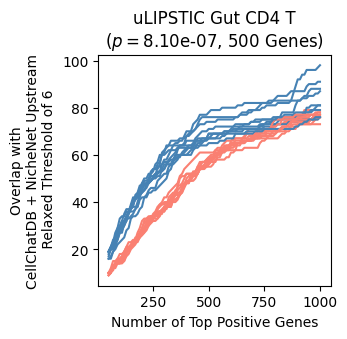

In [40]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with\nCellChatDB + NicheNet Upstream\n Relaxed Threshold of 6'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'uLIPSTIC Gut CD4 T\n($p = ${mytres:.2e}, 500 Genes)'.format(ctype))

Text(0.5, 1.0, 'cDC2 ($p = $2.09e-05, 500 Genes)')

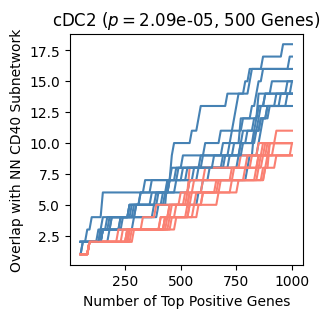

In [53]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with NN CD40 Subnetwork'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'{ctype} ($p = ${mytres:.2e}, 500 Genes)'.format(ctype))